In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from covapt_mt.covapt import covariance_model
from covapt_mt.utils import load_config_file

In [212]:
config_dict = load_config_file("config/get_covariance.yaml")

k_data = np.load(config_dict["input_dir"] + config_dict["k_array_file"])
k_0 = k_data["k_0"]
print(config_dict["output_dir"] + config_dict["covariance_file"])
C_data = np.load(config_dict["output_dir"] + config_dict["covariance_file"])
C_G, P_G = [], []
num_zbins = len(C_data.files)
num_tracers = config_dict["num_tracers"]
num_spectra = int(num_tracers*(num_tracers+1)/2)
num_kbins = len(k_0)

print(k_0, len(k_0))

for z in range(num_zbins):
    C_G.append(C_data["zbin_"+str(z)])
    P_G.append(np.linalg.inv(C_G[z]))

/Users/JoeyA/Research/SPHEREx/covapt_mt/data/output_data/cov_emu_test.npz
[0.00596 0.01388 0.0218  0.02972 0.03764 0.04556 0.05348 0.0614  0.06932
 0.07724 0.08516 0.09308 0.101   0.10892 0.11684 0.12476 0.13268 0.1406
 0.14852 0.15644 0.16436 0.17228 0.1802  0.18812 0.19604] 25


In [213]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

Covariance matrix is positive definite! :)
Correlation matrix is positive definite! :)
0.0 236585185526732.38


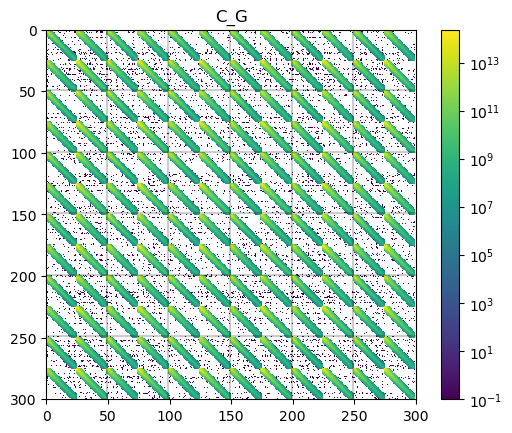

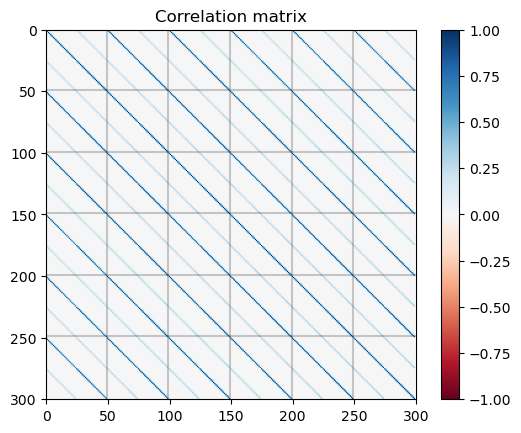

In [214]:
for z in range(num_zbins):

    # idx = np.where(C_G[z] < 1e10)
    # print(idx)
    # C_G[z][idx] = 0
    #C_G[z][(C_G[z] < 10)] = 0
    corr = CorMat(C_G[z])
    
    try:
        L = np.linalg.cholesky(C_G[z])
        print("Covariance matrix is positive definite! :)")
    except:
        print("ERROR! Covariance matrix is not positive definite!")

    try:
        L = np.linalg.cholesky(corr)
        print("Correlation matrix is positive definite! :)")
    except:
        print("ERROR! Correlation matrix is not positive definite!")
    
    print(np.amin(C_G[z]), np.amax(C_G[z]))
    plt.figure()
    plt.title("C_G")
    img = plt.imshow(C_G[z], cmap="viridis",  norm=colors.LogNorm(vmin=0.1, vmax=np.amax(C_G[z])))
    #img = plt.imshow(C_G[z], cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_G[z]), vmax=np.amax(C_G[z])))
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*2 - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*2*num_kbins)
    plt.ylim(num_spectra*2*num_kbins, 0)
    plt.colorbar()
    
    plt.figure()
    plt.title("Correlation matrix")
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*2 - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*2*num_kbins)
    plt.ylim(num_spectra*2*num_kbins, 0)
    plt.colorbar()

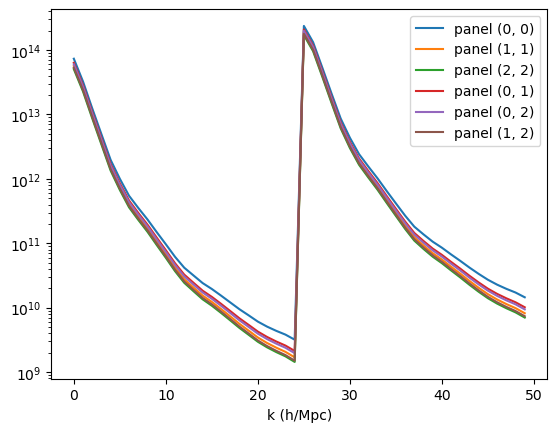

In [215]:
plt.plot(np.diag(C_G[0])[:2*num_kbins], label="panel (0, 0)")
plt.plot(np.diag(C_G[0])[2*num_kbins:4*num_kbins], label="panel (1, 1)")
plt.plot(np.diag(C_G[0])[4*num_kbins:6*num_kbins], label="panel (2, 2)")
plt.plot(np.diag(C_G[0][:2*num_kbins, 2*num_kbins:4*num_kbins]), label="panel (0, 1)")
plt.plot(np.diag(C_G[0][:2*num_kbins, 4*num_kbins:6*num_kbins]), label="panel (0, 2)")
plt.plot(np.diag(C_G[0][2*num_kbins:4*num_kbins, 4*num_kbins:6*num_kbins]), label="panel (1, 2)")
#plt.plot(np.diag(C_G[0])[num_kbins:], label="(2, 2) diagonal")
#plt.xscale("log")
plt.yscale("log")

plt.xlabel("k (h/Mpc)")
plt.legend()

there are 0 negative eigenvalues!
there are 0 eigenvalues equal to 0!


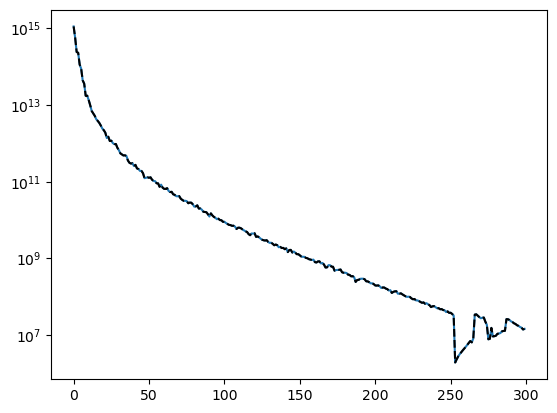

In [216]:
for z in range(num_zbins):
    eigvals_true, __ = np.linalg.eig(C_G[z])
    
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals_true[(eigvals_true < 0)])))
    print("there are {:0.0f} eigenvalues equal to 0!".format(len(eigvals_true[(eigvals_true == 0)])))
    plt.figure()
    plt.plot(eigvals_true)
    plt.plot(abs(eigvals_true), c="black", ls="--")
    plt.yscale("log")

'Fixed' Covariance matrix is positive definite! :)
there are 0 negative eigenvalues!


/var/folders/l_/fjdg3x2d34d0qyk3npf0r2mc0000gn/T/ipykernel_61787/1799195762.py:23: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(100*(C_fixed - C_G[0]) / C_G[0], cmap="RdBu")


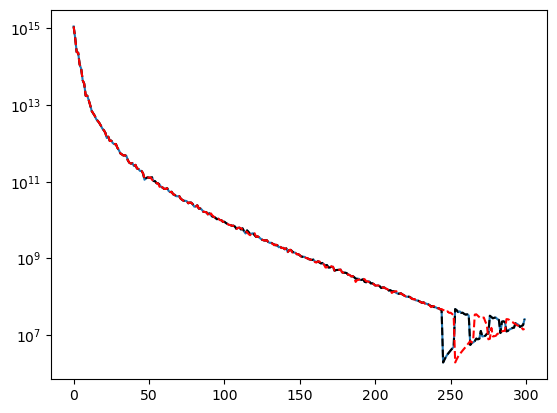

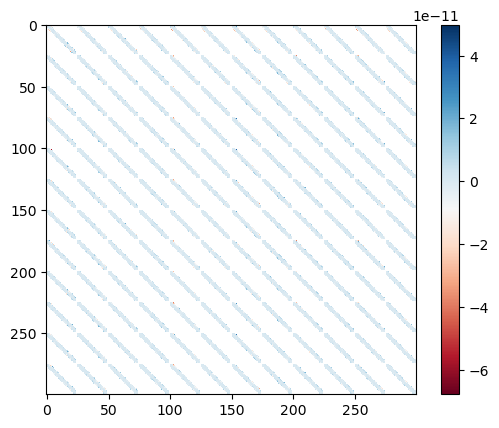

In [217]:
# TEMP FIX: manually set eigenvalues to positive

C_G_fixed = []
for z in range(num_zbins):
    eigvals, Q = np.linalg.eig(C_G[z])
    C_fixed = Q @ (np.diag(abs(eigvals)) @ np.linalg.inv(Q))

    try:
        L = np.linalg.cholesky(C_fixed)
        print("'Fixed' Covariance matrix is positive definite! :)")
    except:
        print("ERROR! 'Fixed' Covariance matrix is not positive definite!")
    
    eigvals, Q = np.linalg.eig(C_fixed)
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals[(eigvals < 0)])))
    plt.figure()
    plt.plot(eigvals)
    plt.plot(abs(eigvals), c="black", ls="--")
    plt.plot(abs(eigvals_true), c="red", ls="--")
    plt.yscale("log")
    
    plt.figure()
    plt.imshow(100*(C_fixed - C_G[0]) / C_G[0], cmap="RdBu")
    plt.colorbar()
    # plt.plot(np.diag(C_G[0]), label="raw matrix")
    # plt.plot(np.diag(C_fixed), ls="--", label="fixed matrix")
    # plt.yscale("log")
    # plt.legend()

In [218]:
def check_leading_principle_minors(cov):
    """A leading principle minora is defined as the determinant of a submatrix with the last n rows / columns
    removed. For a positive-definite block matrix, all leading principle minors should be positive"""
    negative_minors = 0
    n = cov.shape[0]
    for k in range(1, cov.shape[0]):
        cov_sub = cov[:n-k, :n-k]
        det_sign, det = np.linalg.slogdet(cov_sub)
        if det_sign == -1:
            print("k = {:0.0f} has a negative principle minor!".format(k))
            negative_minors += 1
    if negative_minors == 0: print("All leading principle minors are positive")

In [219]:
# check if subsets of the covariance matrix are positive-definite
for z in range(num_zbins):

    check_leading_principle_minors(C_G[z])
    det_sign, det = np.linalg.slogdet(C_G[z])
    print("Log determinant = {:0.3e}".format(det * det_sign))
    
    for i in range(num_spectra):
        for j in range(num_spectra):
            C_sub = C_G[z][i*2*num_kbins: (i+1)*2*num_kbins,j*2*num_kbins: (j+1)*2*num_kbins]
            #check_leading_principle_minors(C_sub)
            det_sign, det = np.linalg.slogdet(C_sub)
            print("sub log determinant = {:0.3e}".format(det * det_sign))
            try:
                L = np.linalg.cholesky(C_sub)
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is positive-definite :)".format(i, j))
            except:
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is NOT positive-definite".format(i, j))
        #print(i*2*num_kbins, j*2*num_kbins)
        #C_sub = C_G[0][

# plt.imshow(CorMat(C_sub), cmap="RdBu", vmin=-1, vmax=1)
# plt.colorbar()

All leading principle minors are positive
Log determinant = 6.459e+03
sub log determinant = 1.300e+03
Partial covariance matrix (0, 0) is positive-definite :)
sub log determinant = 1.287e+03
Partial covariance matrix (0, 1) is positive-definite :)
sub log determinant = 1.284e+03
Partial covariance matrix (0, 2) is positive-definite :)
sub log determinant = 1.275e+03
Partial covariance matrix (0, 3) is positive-definite :)
sub log determinant = 1.272e+03
Partial covariance matrix (0, 4) is positive-definite :)
sub log determinant = 1.269e+03
Partial covariance matrix (0, 5) is positive-definite :)
sub log determinant = 1.287e+03
Partial covariance matrix (1, 0) is positive-definite :)
sub log determinant = 1.279e+03
Partial covariance matrix (1, 1) is positive-definite :)
sub log determinant = 1.275e+03
Partial covariance matrix (1, 2) is positive-definite :)
sub log determinant = 1.271e+03
Partial covariance matrix (1, 3) is positive-definite :)
sub log determinant = 1.267e+03
Partial 

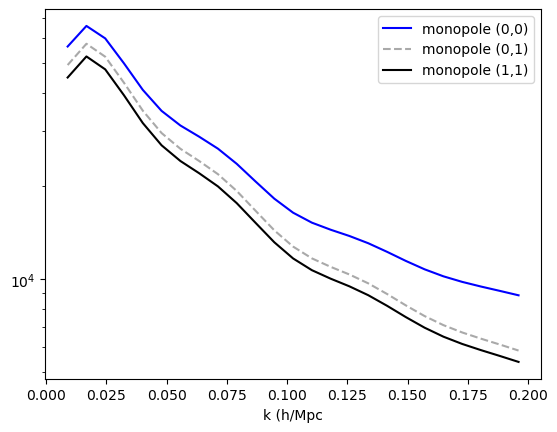

In [ ]:
#pk = np.load("/home/joeadamo/Research/SPHEREx/spherex_emu/data/ps_fid.npy")
pk= np.load("/Users/JoeyA/Research/SPHEREx/covapt_mt/data/input_data/ps_emu_test_2_tracers.npy")

# plt.plot(pk[0,0,0,:], label="idx 0")
# plt.plot(pk_2[0,0,0,:], ls="--", label="idx 0 2")
# plt.plot(pk[0,0,1,:], label="idx 1")
# plt.plot(pk_2[0,0,1,:], ls="--", label="idx 1 2")
# plt.legend()
# plt.yscale("log")

plt.figure()
plt.plot(k_0, pk[0,0,0,:], c="blue", label="monopole (0,0)")
#plt.plot(pk[0,3,0,:], c="red",label="monopole (1,1)")
#plt.plot(pk[0,5,0,:], c="green",label="monopole (2,2)")
#plt.axhline(1. / 0.00282, c="red", ls="--")
plt.plot(k_0, pk[0,1,0,:], c="darkgrey", ls="--", label="monopole (0,1)")
plt.plot(k_0, pk[0,2,0,:], c="black", label="monopole (1,1)")
#plt.plot(pk[0,4,0,:], c="grey", ls="--", label="monopole (1,2)")
plt.legend()
plt.xlabel("k (h/Mpc")
plt.yscale("log")

In [210]:
# Save the k array
#k = np.array([0.00694, 0.01482, 0.0227, 0.03058, 0.03846, 0.04634, 0.05422, 0.0621, 0.06998,
#              0.07786, 0.08574, 0.09362, 0.1015,  0.10938, 0.11726, 0.12514, 0.13302, 0.1409,
#              0.14878, 0.15666, 0.16454, 0.17242, 0.1803,  0.18818, 0.19606])
k = np.linspace(0.002, 0.2, 26)
k_centers = (k[:-1] + k[1:]) / 2
print(k_centers, len(k_centers))
np.savez("data/input_data/k_emu_test.npz", k_0=k_centers)

[0.00596 0.01388 0.0218  0.02972 0.03764 0.04556 0.05348 0.0614  0.06932
 0.07724 0.08516 0.09308 0.101   0.10892 0.11684 0.12476 0.13268 0.1406
 0.14852 0.15644 0.16436 0.17228 0.1802  0.18812 0.19604] 25
